In [3]:
import pandas as pd
import numpy as np
import os
import pickle
import torch
import sys
from helpers_task_detector import *
sys.path.append('../')
from src.helpers import *
from src.visualize import *
from src.trainer import *
from src.trainer_hnet import * 
from Models.models import *
import json

import seaborn as sns
import matplotlib.pyplot as plt

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load the list of experiments from JSON
with open(os.path.join('config.json'), 'r') as f:
    experiments = json.load(f)
    
path_to_hnets = './Models/Models_HNET'

# Experiment 0: Assessing Catastrophic Forgetting

### To have more robust results, once data was generated we permuted the task order 3 times, always keeping the baseline as the first task.

#### Here the first version of the experiment, we will call it V0.

In [5]:
experiment0_hnet_v0 = 'Experiment76'
models_exp0_hnet_v0 = np.sort(os.listdir(os.path.join(path_to_hnets, experiment0_hnet_v0)))


path_results_exp0_v0 = './Results/' + experiment0_hnet_v0
with open(os.path.join(path_results_exp0_v0 +'.pkl'), 'rb') as fp:
    results_hnet_exp0_v0 = pickle.load(fp)

data_path_exp0_v0 = './Data/Sim_Data_'+'Experiment60_sorted'+'.pkl'
with open(os.path.join(data_path_exp0_v0), 'rb') as fp:
    data_exp0_v0 = pickle.load(fp)

In [4]:
df_exp0_v0 = build_catas_forg_df(results_hnet_exp0_v0, data_exp0_v0, models_exp0_hnet_v0, experiment0_hnet_v0)

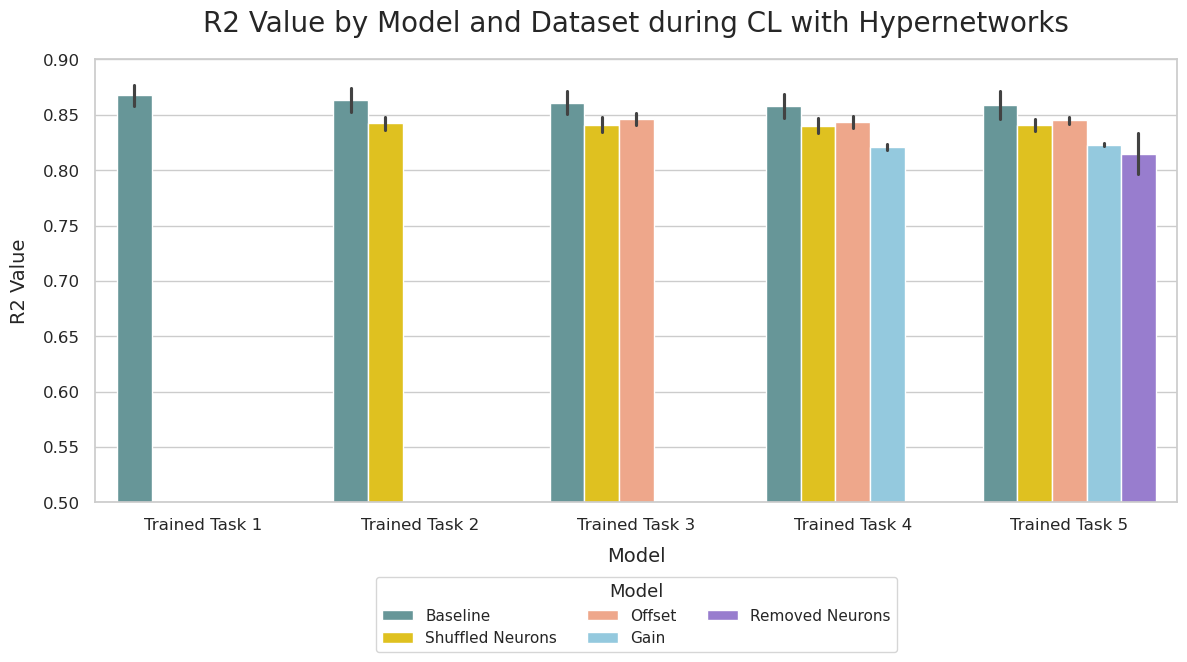

In [5]:
plot_catas_forg(df_exp0_v0)

#### Here the second version of the experiment, we will call it V1.

In [6]:
experiment0_hnet_v1 = 'Experiment78'
models_exp0_hnet_v1 = np.sort(os.listdir(os.path.join(path_to_hnets, experiment0_hnet_v1)))


path_results_exp0_v1 = './Results/' + experiment0_hnet_v1
with open(os.path.join(path_results_exp0_v1 +'.pkl'), 'rb') as fp:
    results_hnet_exp0_v1 = pickle.load(fp)

data_path_exp0_v1 = './Data/Sim_Data_'+'Experiment60_sorted_v2'+'.pkl'
with open(os.path.join(data_path_exp0_v1), 'rb') as fp:
    data_exp0_v1 = pickle.load(fp)


In [7]:
df_exp0_v1 = build_catas_forg_df(results_hnet_exp0_v1, data_exp0_v1, models_exp0_hnet_v1, experiment0_hnet_v1)

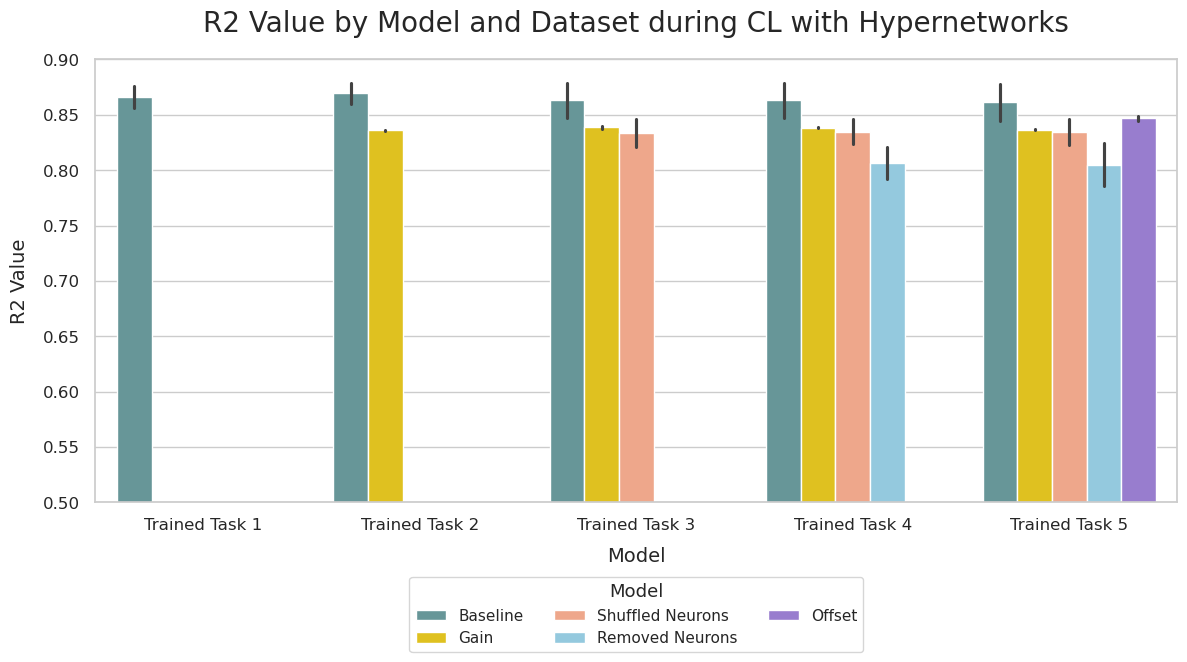

In [8]:
plot_catas_forg(df_exp0_v1)

#### Here the third version of the experiment, we will call it V2.

In [9]:
experiment0_hnet_v2 = 'Experiment79_moreB'
models_exp0_hnet_v2 = np.sort(os.listdir(os.path.join(path_to_hnets, experiment0_hnet_v2)))


path_results_exp0_v2 = './Results/' + experiment0_hnet_v2
with open(os.path.join(path_results_exp0_v2 +'.pkl'), 'rb') as fp:
    results_hnet_exp0_v2 = pickle.load(fp)

data_path_exp0_v2 = './Data/Sim_Data_'+'Experiment60_sorted_v3'+'.pkl'
with open(os.path.join(data_path_exp0_v2), 'rb') as fp:
    data_exp0_v2 = pickle.load(fp)


In [10]:
df_exp0_v2 = build_catas_forg_df(results_hnet_exp0_v2, data_exp0_v2, models_exp0_hnet_v2, experiment0_hnet_v2)

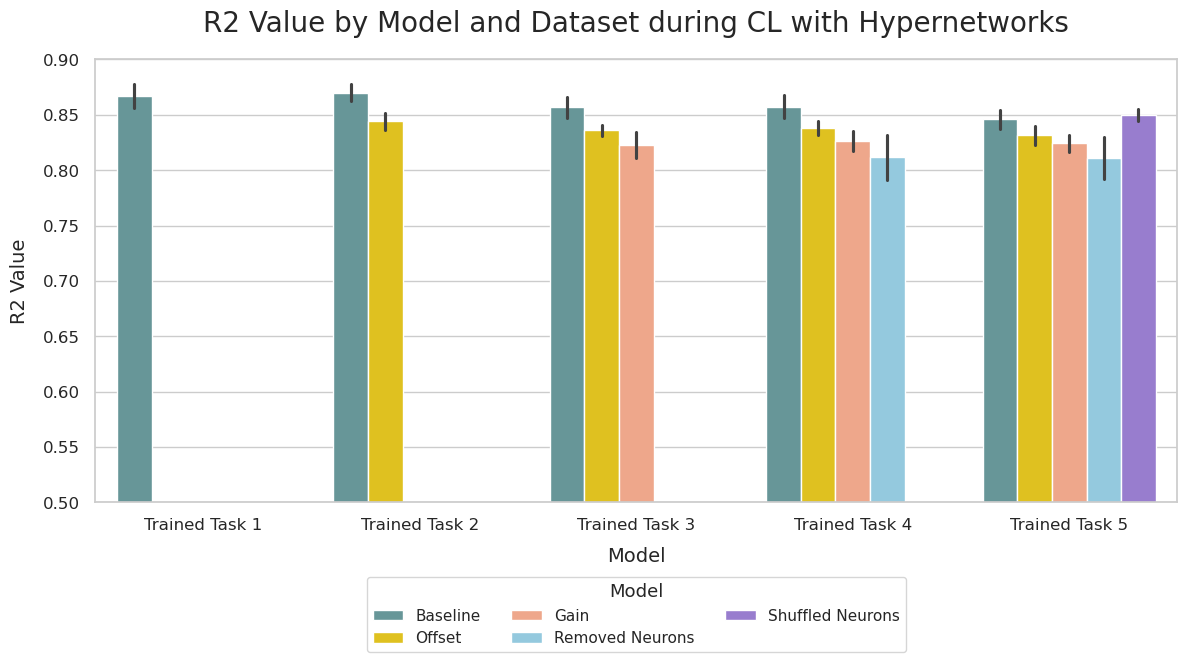

In [11]:
plot_catas_forg(df_exp0_v2)

# Experiment 1: Comparison with other methods

In [12]:
experiment1_control = 'Experiment76_control'
models_exp1_control = np.sort(os.listdir(os.path.join(path_to_hnets, experiment1_control)))

path_results_exp1_control = './Results/' + experiment1_control
with open(os.path.join(path_results_exp1_control +'.pkl'), 'rb') as fp:
    results_exp1_control = pickle.load(fp)

data_path_exp1_control = './Data/Sim_Data_'+'Experiment60_sorted'+'.pkl'

with open(os.path.join(data_path_exp1_control), 'rb') as fp:
    data_exp1_control = pickle.load(fp)

Define the dataframes for each experiment. 

In [13]:
df_exp1_control = build_result_df(results_exp1_control, data_exp1_control)
df_exp0_hnet_v0 = build_result_df(results_hnet_exp0_v0, data_exp0_v0)
df_exp0_hnet_v1 = build_result_df(results_hnet_exp0_v1, data_exp0_v1)
df_exp0_hnet_v2 = build_result_df(results_hnet_exp0_v2, data_exp0_v2)

Keep only the tasks learned and sort the dataframes in the order of the learned tasks.

In [14]:
# For the control experiment
df_exp1_control_new = df_exp1_control.loc[df_exp1_control.New_Task == True].reset_index()
df_exp1_control_new.sort_values(by='Dataset', inplace=True)
df_exp1_control_new = df_exp1_control_new.reset_index().drop(columns = ['index'])

# For the first version of the experiment
df_exp0_hnet_new_v0 = df_exp0_hnet_v0.loc[df_exp0_hnet_v0.New_Task == True].reset_index()
df_exp0_hnet_new_v0.sort_values(by='True_Task', inplace=True)
df_exp0_hnet_new_v0 = df_exp0_hnet_new_v0.reset_index()

# For the second version of the experiment
df_exp0_hnet_new_v1 = df_exp0_hnet_v1.loc[df_exp0_hnet_v1.New_Task == True].reset_index()
df_exp0_hnet_new_v1.sort_values(by='True_Task', inplace=True)
df_exp0_hnet_new_v1 = df_exp0_hnet_new_v1.reset_index()

# For the third version of the experiment
df_exp0_hnet_new_v2 = df_exp0_hnet_v2.loc[df_exp0_hnet_v2.New_Task == True].reset_index()
df_exp0_hnet_new_v2.sort_values(by='True_Task', inplace=True)
df_exp0_hnet_new_v2 = df_exp0_hnet_new_v2.reset_index()



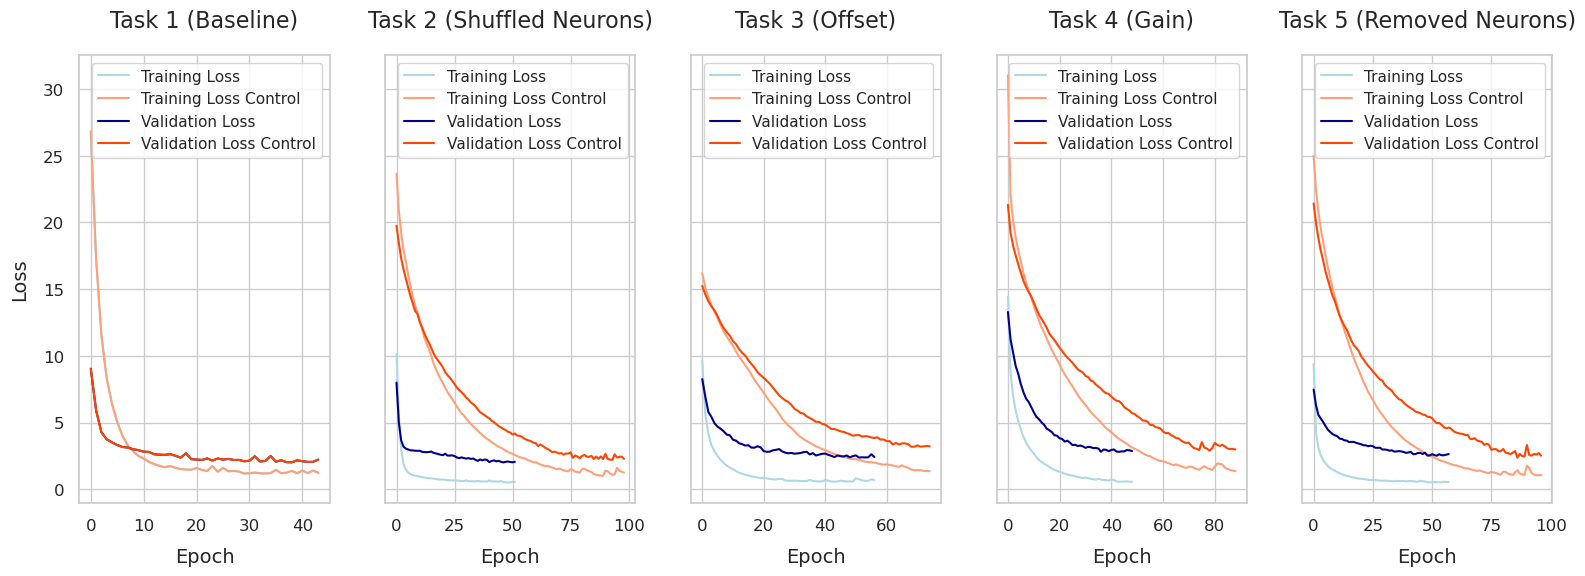

In [15]:
plot_learning_curves(df_exp0_hnet_new_v0, df_exp1_control_new)

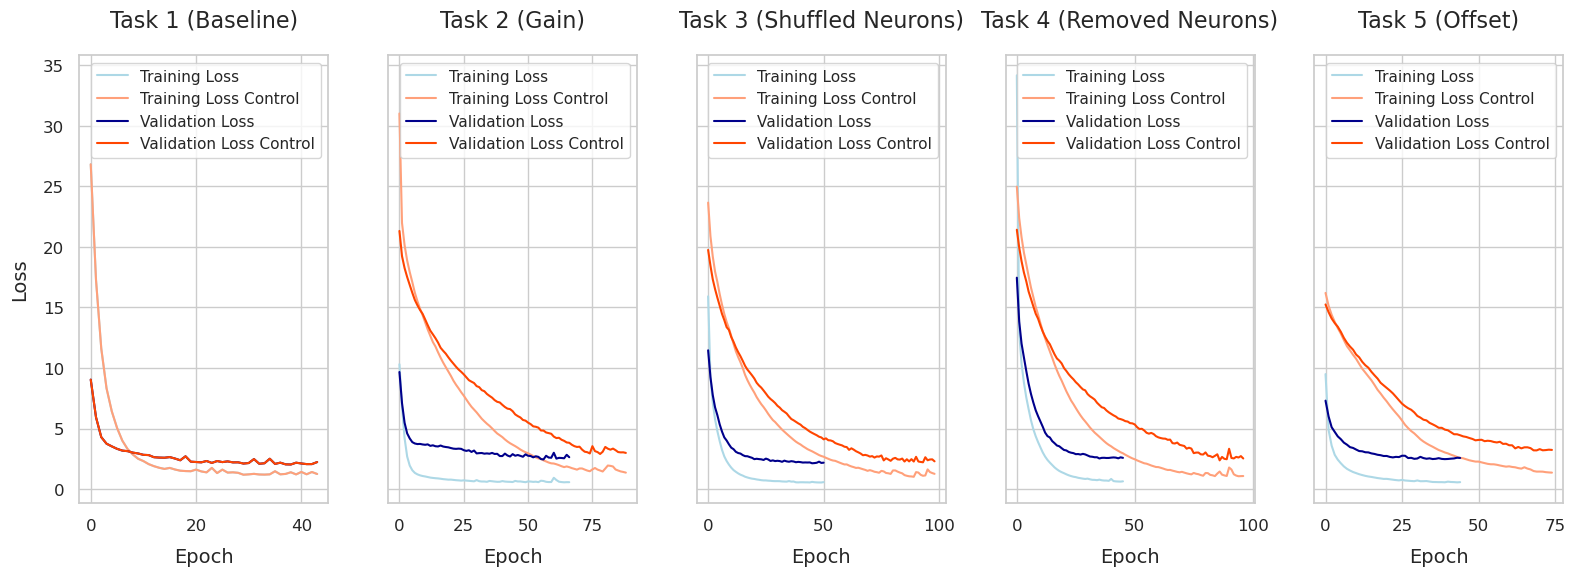

In [16]:
plot_learning_curves(df_exp0_hnet_new_v1, df_exp1_control)

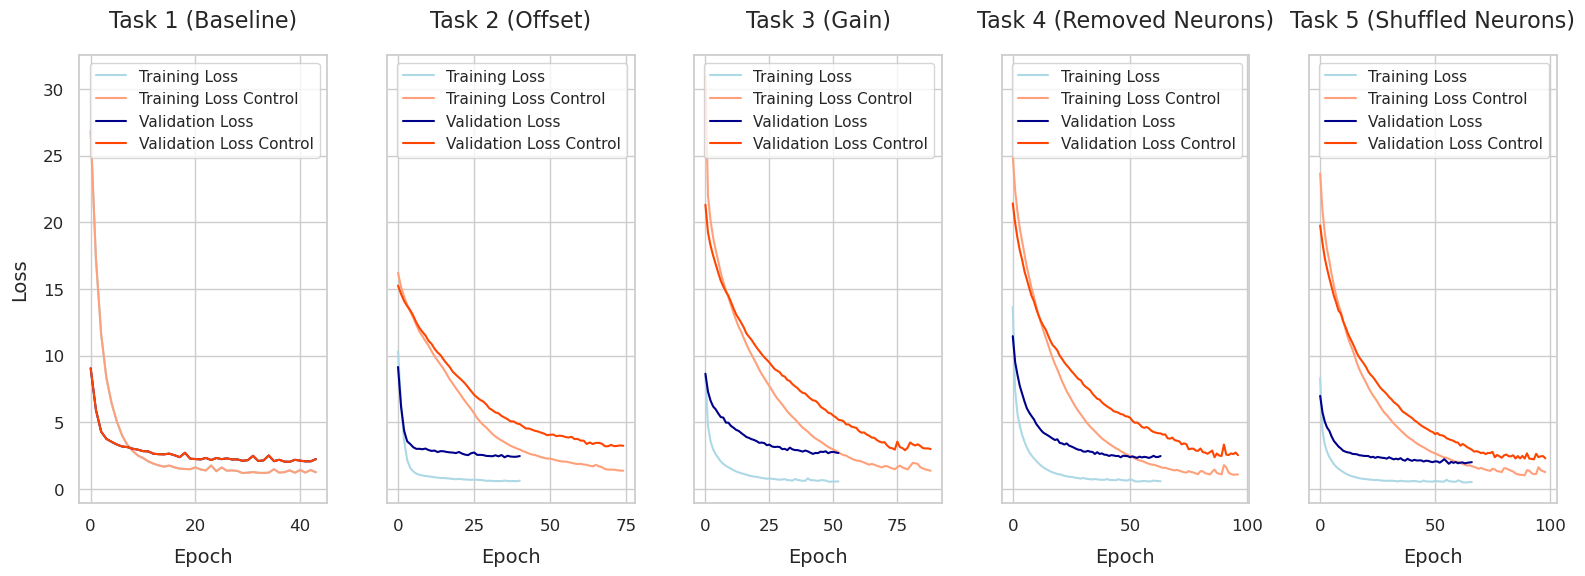

In [17]:
plot_learning_curves(df_exp0_hnet_new_v2, df_exp1_control)

### Including the other methods: EWC and Fine Tuning.

#### Start with the first version

In [18]:
experiment1_EWC_v0 = 'Experiment77'

path_to_ewc = './Models/Models_EWC'
models_exp1_EWC_v0 = np.sort(os.listdir(os.path.join(path_to_ewc, experiment1_EWC_v0)))

path_results_exp1_EWC_v0 = './Results/' + experiment1_EWC_v0
with open(os.path.join(path_results_exp1_EWC_v0 +'_EWC.pkl'), 'rb') as fp:
    results_exp1_EWC_v0 = pickle.load(fp)

data_path_exp1_EWC_v0 = './Data/Sim_Data_'+'Experiment60_sorted_first5'+'.pkl'
with open(os.path.join(data_path_exp1_EWC_v0), 'rb') as fp:
    data_exp1_EWC_v0 = pickle.load(fp)

In [19]:
df_exp1_EWC_v0 = build_result_df(results_exp1_EWC_v0, data_exp1_EWC_v0, EWC = True)

In [20]:
df_exp1_EWC_plot_v0 = build_catas_forg_df(results_exp1_EWC_v0, \
    data_exp1_EWC_v0, 
    models_exp1_EWC_v0, 
    experiment1_EWC_v0, 
    model_type = 'EWC')

In [21]:
r2_ewc_v0 = df_exp1_EWC_plot_v0.loc[df_exp1_EWC_plot_v0.Model == 'Model_Task_4.pth'][['Name', 'R2']]
r2_ewc_v0.rename(columns={'R2': 'EWC Model'}, inplace=True)

### Second version

In [22]:
experiment1_EWC_v1 = 'Experiment92'

path_to_ewc = './Models/Models_EWC'
models_exp1_EWC_v1 = np.sort(os.listdir(os.path.join(path_to_ewc, experiment1_EWC_v1)))

path_results_exp1_EWC_v1 = './Results/' + experiment1_EWC_v1
with open(os.path.join(path_results_exp1_EWC_v1 + '_EWC.pkl'), 'rb') as fp:
    results_exp1_EWC_v1 = pickle.load(fp)

data_path_exp1_EWC_v1 = './Data/Sim_Data_Experiment60_sorted_first5_v2' + '.pkl'
with open(os.path.join(data_path_exp1_EWC_v1), 'rb') as fp:
    data_exp1_EWC_v1 = pickle.load(fp)

df_exp1_EWC_v1 = build_result_df(results_exp1_EWC_v1, data_exp1_EWC_v1, EWC=True)
df_exp1_EWC_plot_v1 = build_catas_forg_df(results_exp1_EWC_v1, 
                                          data_exp1_EWC_v1, 
                                          models_exp1_EWC_v1, 
                                          experiment1_EWC_v1, 
                                          model_type='EWC')
r2_ewc_v1 = df_exp1_EWC_plot_v1.loc[df_exp1_EWC_plot_v1.Model == 'Model_Task_4.pth'][['Name', 'R2']]
r2_ewc_v1.rename(columns={'R2': 'EWC Model'}, inplace=True)

### Third version

In [23]:
experiment1_EWC_v2 = 'Experiment93'

path_to_ewc = './Models/Models_EWC'
models_exp1_EWC_v2 = np.sort(os.listdir(os.path.join(path_to_ewc, experiment1_EWC_v2)))

path_results_exp1_EWC_v2 = './Results/' + experiment1_EWC_v2
with open(os.path.join(path_results_exp1_EWC_v2 + '_EWC.pkl'), 'rb') as fp:
    results_exp1_EWC_v2 = pickle.load(fp)

data_path_exp1_EWC_v2 = './Data/Sim_Data_Experiment60_sorted_first5_v3' + '.pkl'
with open(os.path.join(data_path_exp1_EWC_v2), 'rb') as fp:
    data_exp1_EWC_v2 = pickle.load(fp)

df_exp1_EWC_v2 = build_result_df(results_exp1_EWC_v2, data_exp1_EWC_v2, EWC=True)
df_exp1_EWC_plot_v2 = build_catas_forg_df(results_exp1_EWC_v2, 
                                          data_exp1_EWC_v2, 
                                          models_exp1_EWC_v2, 
                                          experiment1_EWC_v2, 
                                          model_type='EWC')
r2_ewc_v2 = df_exp1_EWC_plot_v2.loc[df_exp1_EWC_plot_v2.Model == 'Model_Task_4.pth'][['Name', 'R2']]
r2_ewc_v2.rename(columns={'R2': 'EWC Model'}, inplace=True)


### Now for the Fine Tuning version

In [24]:
# For v0
experiment1_FT_v0 = 'Experiment77'

path_to_ft = './Models/Models_FT'
models_exp1_FT_v0 = np.sort(os.listdir(os.path.join(path_to_ft, 'Experiment77')))

path_results_exp1_FT_v0 = './Results/' + experiment1_FT_v0
with open(os.path.join(path_results_exp1_FT_v0 + '_FT.pkl'), 'rb') as fp:
    results_exp1_FT_v0 = pickle.load(fp)

data_path_exp1_FT_v0 = './Data/Sim_Data_Experiment60_sorted_first5' + '.pkl'
with open(os.path.join(data_path_exp1_FT_v0), 'rb') as fp:
    data_exp1_FT_v0 = pickle.load(fp)

df_exp1_FT_v0 = build_result_df(results_exp1_FT_v0, data_exp1_FT_v0, EWC=True)
df_exp1_FT_plot_v0 = build_catas_forg_df(results_exp1_FT_v0, 
                                         data_exp1_FT_v0, 
                                         models_exp1_FT_v0, 
                                         experiment1_FT_v0, 
                                         model_type='FT')


r2_ft_v0 = df_exp1_FT_plot_v0.loc[df_exp1_FT_plot_v0.Model == 'Model_Task_4.pth'][['Name', 'R2']]
r2_ft_v0.rename(columns={'R2': 'FT Model'}, inplace=True)

In [25]:
# For v1
experiment1_FT_v1 = 'Experiment92'

path_to_ft = './Models/Models_FT'
models_exp1_FT_v1 = np.sort(os.listdir(os.path.join(path_to_ft, experiment1_FT_v1)))

path_results_exp1_FT_v1 = './Results/' + experiment1_FT_v1
with open(os.path.join(path_results_exp1_FT_v1 + '_FT.pkl'), 'rb') as fp:
    results_exp1_FT_v1 = pickle.load(fp)

data_path_exp1_FT_v1 = './Data/Sim_Data_Experiment60_sorted_first5_v2' + '.pkl'
with open(os.path.join(data_path_exp1_FT_v1), 'rb') as fp:
    data_exp1_FT_v1 = pickle.load(fp)

df_exp1_FT_v1 = build_result_df(results_exp1_FT_v1, data_exp1_FT_v1, EWC=True)
df_exp1_FT_plot_v1 = build_catas_forg_df(results_exp1_FT_v1, 
                                         data_exp1_FT_v1, 
                                         models_exp1_FT_v1, 
                                         experiment1_FT_v1, 
                                         model_type='FT')
r2_ft_v1 = df_exp1_FT_plot_v1.loc[df_exp1_FT_plot_v1.Model == 'Model_Task_4.pth'][['Name', 'R2']]
r2_ft_v1.rename(columns={'R2': 'FT Model'}, inplace=True)



In [26]:
# For v2
experiment1_FT_v2 = 'Experiment93'

path_to_ft = './Models/Models_FT'
models_exp1_FT_v2 = np.sort(os.listdir(os.path.join(path_to_ft, experiment1_FT_v2)))

path_results_exp1_FT_v2 = './Results/' + experiment1_FT_v2
with open(os.path.join(path_results_exp1_FT_v2 + '_FT.pkl'), 'rb') as fp:
    results_exp1_FT_v2 = pickle.load(fp)

data_path_exp1_FT_v2 = './Data/Sim_Data_Experiment60_sorted_first5_v3' + '.pkl'
with open(os.path.join(data_path_exp1_FT_v2), 'rb') as fp:
    data_exp1_FT_v2 = pickle.load(fp)

df_exp1_FT_v2 = build_result_df(results_exp1_FT_v2, data_exp1_FT_v2, EWC= True)
df_exp1_FT_plot_v2 = build_catas_forg_df(results_exp1_FT_v2, 
                                         data_exp1_FT_v2, 
                                         models_exp1_FT_v2, 
                                         experiment1_FT_v2, 
                                         model_type='FT')
r2_ft_v2 = df_exp1_FT_plot_v2.loc[df_exp1_FT_plot_v2.Model == 'Model_Task_4.pth'][['Name', 'R2']]
r2_ft_v2.rename(columns={'R2': 'FT Model'}, inplace=True)

### Plotting the comparison barplot between models

In [27]:
r2_control_v0 =df_exp1_control_new[['Dataset', 'R2_hnet']]
r2_control_v0.rename(columns={'R2_hnet': 'Single Task Model'}, inplace=True)
r2_hnet_during_v0 = df_exp0_hnet_new_v0[['Dataset', 'R2_hnet', 'True_Task']]
r2_hnet_during_v0.rename(columns={'R2_hnet': 'HNET During'}, inplace=True)
r2_hnet_end_v0 = pd.DataFrame(df_exp0_v0.loc[df_exp0_v0.Model == 'Model_Task_4.pth'].groupby(['Name','Dataset'])['R2'].mean().reset_index())
r2_hnet_end_v0.rename(columns={'R2': 'HNET'}, inplace=True)

/tmp/ipykernel_237565/4062593693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r2_control_v0.rename(columns={'R2_hnet': 'Single Task Model'}, inplace=True)
/tmp/ipykernel_237565/4062593693.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r2_hnet_during_v0.rename(columns={'R2_hnet': 'HNET During'}, inplace=True)


In [28]:
comparison_table_v0 = r2_hnet_end_v0.merge(r2_hnet_during_v0, on = ['Dataset'])
comparison_table_v0 = comparison_table_v0.merge(r2_control_v0, on = ['Dataset'])
comparison_table_v0 = comparison_table_v0.sort_values(by='True_Task')
comparison_table_v0 = comparison_table_v0.merge(r2_ewc_v0, on = ['Name'])
comparison_table_v0 = comparison_table_v0.merge(r2_ft_v0, on = ['Name'])

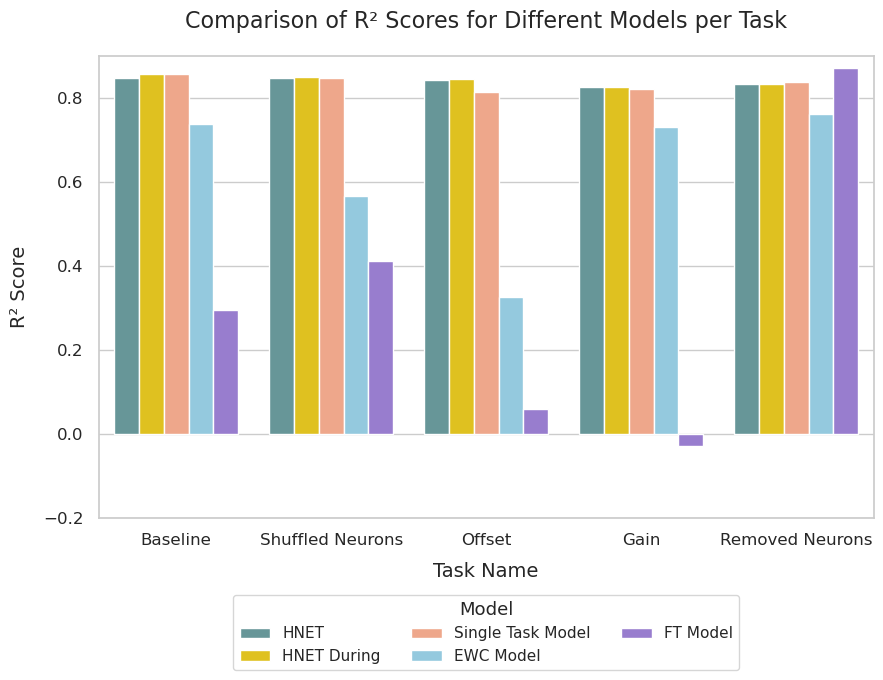

In [29]:
plot_comparison(comparison_table_v0)

/tmp/ipykernel_237565/1253349907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r2_control_v1.rename(columns={'R2_hnet': 'Single Task Model'}, inplace=True)
/tmp/ipykernel_237565/1253349907.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r2_hnet_during_v1.rename(columns={'R2_hnet': 'HNET During'}, inplace=True)


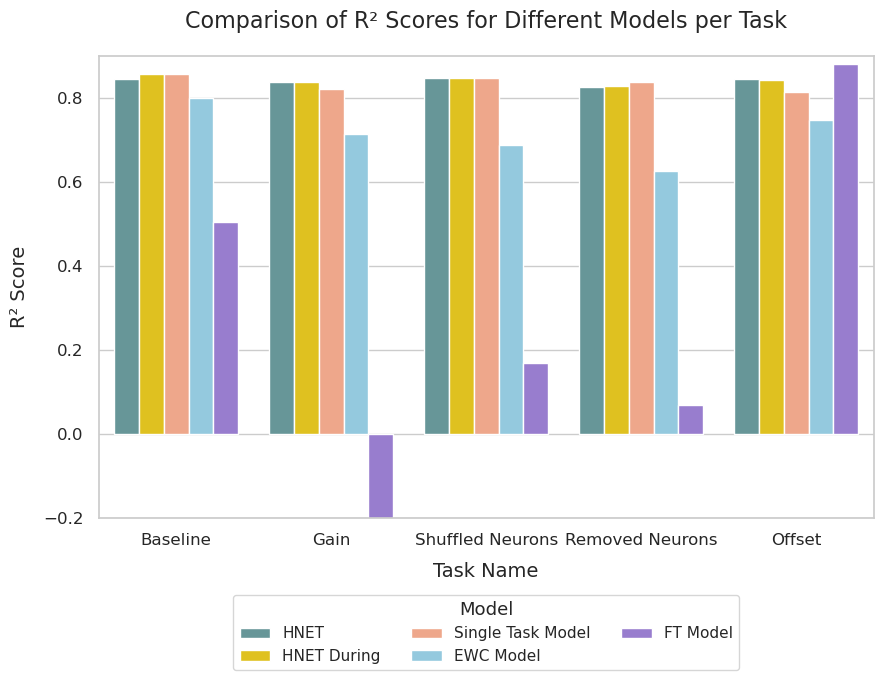

In [30]:
# Preparing the data for version v1
r2_control_v1 = df_exp1_control_new[['Dataset', 'R2_hnet']]
r2_control_v1.rename(columns={'R2_hnet': 'Single Task Model'}, inplace=True)
r2_hnet_during_v1 = df_exp0_hnet_new_v1[['Dataset', 'R2_hnet', 'True_Task']]
r2_hnet_during_v1.rename(columns={'R2_hnet': 'HNET During'}, inplace=True)
r2_hnet_end_v1 = pd.DataFrame(df_exp0_v1.loc[df_exp0_v1.Model == 'Model_Task_4.pth'].groupby(['Name','Dataset'])['R2'].mean().reset_index())
r2_hnet_end_v1.rename(columns={'R2': 'HNET'}, inplace=True)

comparison_table_v1 = r2_hnet_end_v1.merge(r2_hnet_during_v1, on=['Dataset'])
comparison_table_v1 = comparison_table_v1.merge(r2_control_v1, on=['Dataset'])
comparison_table_v1 = comparison_table_v1.sort_values(by='True_Task')
comparison_table_v1 = comparison_table_v1.merge(r2_ewc_v1, on=['Name'])
comparison_table_v1 = comparison_table_v1.merge(r2_ft_v1, on=['Name'])

plot_comparison(comparison_table_v1)


/tmp/ipykernel_237565/1755200647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r2_control_v2.rename(columns={'R2_hnet': 'Single Task Model'}, inplace=True)
/tmp/ipykernel_237565/1755200647.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r2_hnet_during_v2.rename(columns={'R2_hnet': 'HNET During'}, inplace=True)


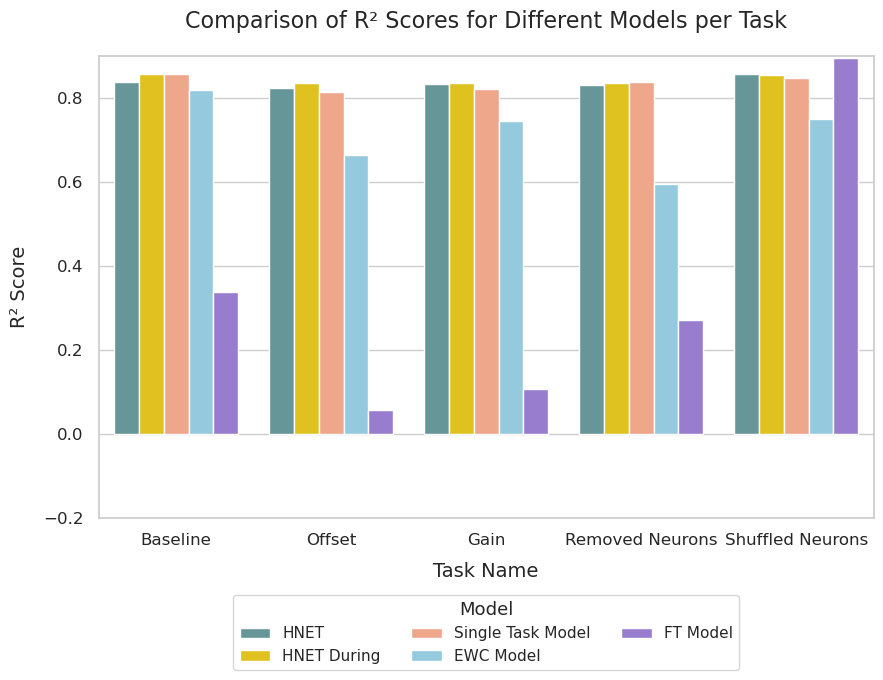

In [31]:
# Preparing the data for version v2
r2_control_v2 = df_exp1_control_new[['Dataset', 'R2_hnet']]
r2_control_v2.rename(columns={'R2_hnet': 'Single Task Model'}, inplace=True)
r2_hnet_during_v2 = df_exp0_hnet_new_v2[['Dataset', 'R2_hnet', 'True_Task']]
r2_hnet_during_v2.rename(columns={'R2_hnet': 'HNET During'}, inplace=True)
r2_hnet_end_v2 = pd.DataFrame(df_exp0_v2.loc[df_exp0_v2.Model == 'Model_Task_4.pth'].groupby(['Name','Dataset'])['R2'].mean().reset_index())
r2_hnet_end_v2.rename(columns={'R2': 'HNET'}, inplace=True)

comparison_table_v2 = r2_hnet_end_v2.merge(r2_hnet_during_v2, on=['Dataset'])
comparison_table_v2 = comparison_table_v2.merge(r2_control_v2, on=['Dataset'])
comparison_table_v2 = comparison_table_v2.sort_values(by='True_Task')
comparison_table_v2 = comparison_table_v2.merge(r2_ewc_v2, on=['Name'])
comparison_table_v2 = comparison_table_v2.merge(r2_ft_v2, on=['Name'])

plot_comparison(comparison_table_v2)

# Experiment 2: Task order effect

In [6]:
def create_df_task_order(experiments, idx_start, idx_end):
    second_task = []
    third_task = []
    r2 = []

    for exp in range(idx_start, idx_end):
        experiment= experiments[exp]

        name = experiment['experiment_name']
        # Loading data
        data = experiment['data']
        data_dir = "./Data/"
        with open(os.path.join(data_dir, data +'.pkl'), 'rb') as fp:
            sets = pickle.load(fp)

        data2, data3 = list(sets.keys())[1:]
        second_task.append(data2)
        third_task.append(data3)

        path_to_hnets = './Models/Models_HNET'
        models_task2 = torch.load(os.path.join(path_to_hnets,name, 'Model_Task_2.pth'))

        W = models_task2(cond_id = int(2))
        main_net = RNN_Main_Model(num_features= 130, hnet_output = W,  hidden_size = 300,
                            num_layers= 1,out_dims=2,  
                            dropout= 0.2,  LSTM_ = False)
        x_train, y_train, x_val, y_val, x_test, y_test = sets[data3]
        r2_, _ = calc_explained_variance_mnet(x_test, y_test, W, main_net)
        
        r2.append(r2_)

    df_order = pd.DataFrame([second_task, third_task, r2]).T
    df_order.columns = ['Second Trained Task', 'Third Trained Task', 'R2 Third Task']
    return df_order

In [7]:
df_order_0 = create_df_task_order(experiments, 79, 91)
df_order_1 = create_df_task_order(experiments, 160, 172)
df_order_2 = create_df_task_order(experiments, 174, 186)
df_order_0_half2 = create_df_task_order(experiments, 186, 198)
df_order_1_half2 = create_df_task_order(experiments, 198, 210)
df_order_complete = pd.concat([df_order_0, df_order_1, df_order_2, df_order_0_half2, df_order_1_half2])

In [8]:
df = df_order_complete

# Mapping function
def map_perturbed_task(value):
    perturbed_task = value.split('_')[1]
    if perturbed_task == '0':
        return 'Baseline'
    elif perturbed_task == '1':
        return 'Removed'
    elif perturbed_task == '2':
        return 'Shuffled'
    elif perturbed_task == '3':
        return 'Gain'
    elif perturbed_task == '4':
        return 'Offset'
    else:
        return value

In [9]:
# Apply the mapping to the columns
df['Second Trained Task'] = df['Second Trained Task'].apply(map_perturbed_task)
df['Third Trained Task'] = df['Third Trained Task'].apply(map_perturbed_task)
df['R2 Third Task'] = pd.to_numeric(df['R2 Third Task'])

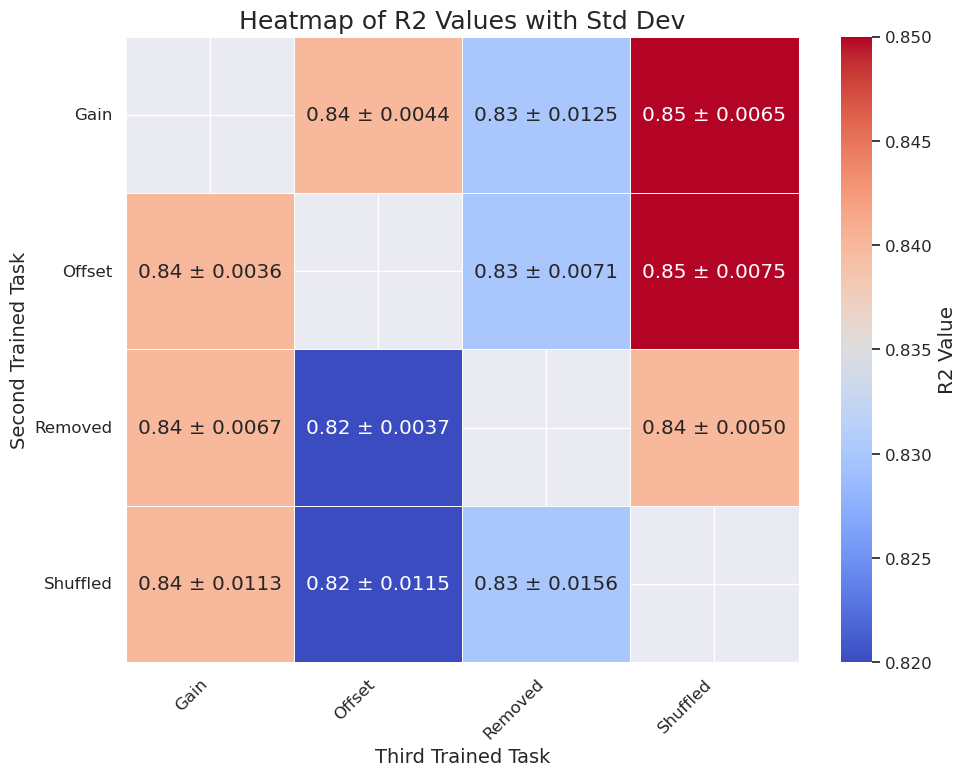

In [10]:
plot_order_heatmap(df)

# Experiment 3: Determining the minimum trial number to learn and identify tasks

Experiments from 76 to 128 (from 1 to 54 trials)

In [36]:
exp_num_trials = {'Experiment76' : 54,
                  'Experiment94': 1, 
                  'Experiment95': 5,
                  'Experiment96': 10, 
                  'Experiment97': 15, 
                  'Experiment98': 20, 
                  'Experiment99': 25, 
                  'Experiment100': 30, 
                  'Experiment101': 35, 
                  'Experiment102': 40,
                  'Experiment103': 45, 
                  'Experiment104': 50,
                  'Experiment105': 1, 
                  'Experiment106': 5,
                  'Experiment107': 10, 
                  'Experiment108': 15, 
                  'Experiment109': 20, 
                  'Experiment110': 25, 
                  'Experiment111': 30, 
                  'Experiment112': 35, 
                  'Experiment113': 40,
                  'Experiment114': 45, 
                  'Experiment115': 50,
                  'Experiment116': 54,
                  'Experiment117' : 1, 
                  'Experiment118': 5,
                  'Experiment119': 10,
                  'Experiment120' : 15, 
                  'Experiment121' : 20,
                  'Experiment122': 25,
                  'Experiment123': 30, 
                  'Experiment124' : 35,
                  'Experiment125' : 40,
                  'Experiment126': 45, 
                  'Experiment127' : 50,
                  'Experiment128' : 54,
                  }

In [37]:
df_results_min_learning = average_results(exp_num_trials)

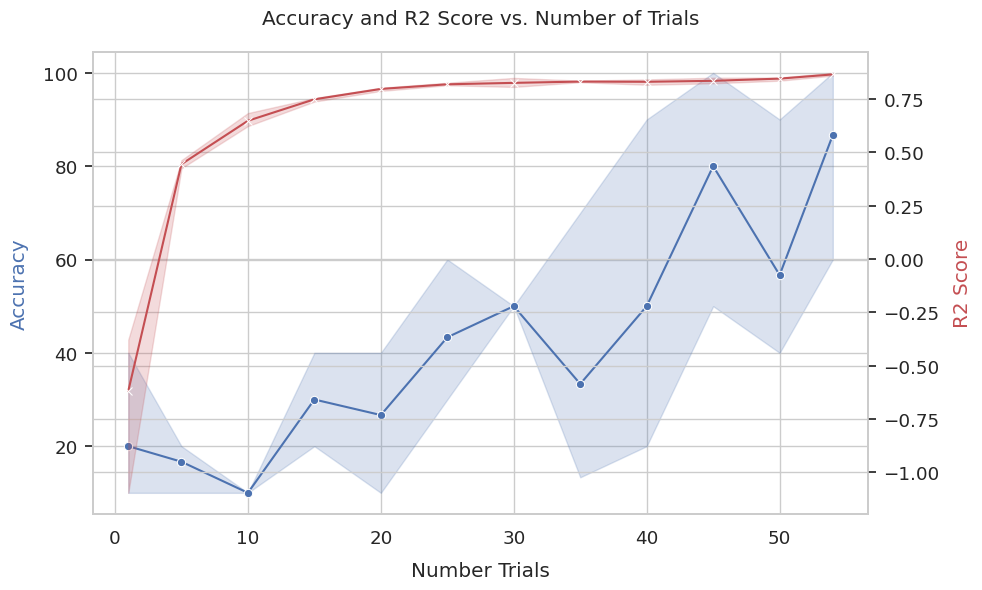

In [38]:
plot_min_trial_leaning(df_results_min_learning)

### Check here how many trials are needed for a task to be detected once it has been pre-trained.

In [39]:
exp3_min_infering = 'Experiment76'
data_name_exp3 = 'Experiment60_sorted'
data_path_exp3 = './Data/Sim_Data_'+data_name_exp3+'.pkl'
with open(os.path.join(data_path_exp3), 'rb') as fp:
    data_exp3 = pickle.load(fp)

In [40]:
df_exp3_1 = build_df_exp3(exp3_min_infering, data_exp3)
accuracy_by_num_trials = df_exp3_1.groupby(['Num Trials', 'True Task']).apply(lambda group: (group['True Task'] == group['Predicted Task']).mean())
accuracy_by_num_trials.name = 'Accuracy'
df_exp3_2 = pd.DataFrame(accuracy_by_num_trials.reset_index())
df_exp3 = df_exp3_1.merge(df_exp3_2, on = ['Num Trials', 'True Task'])

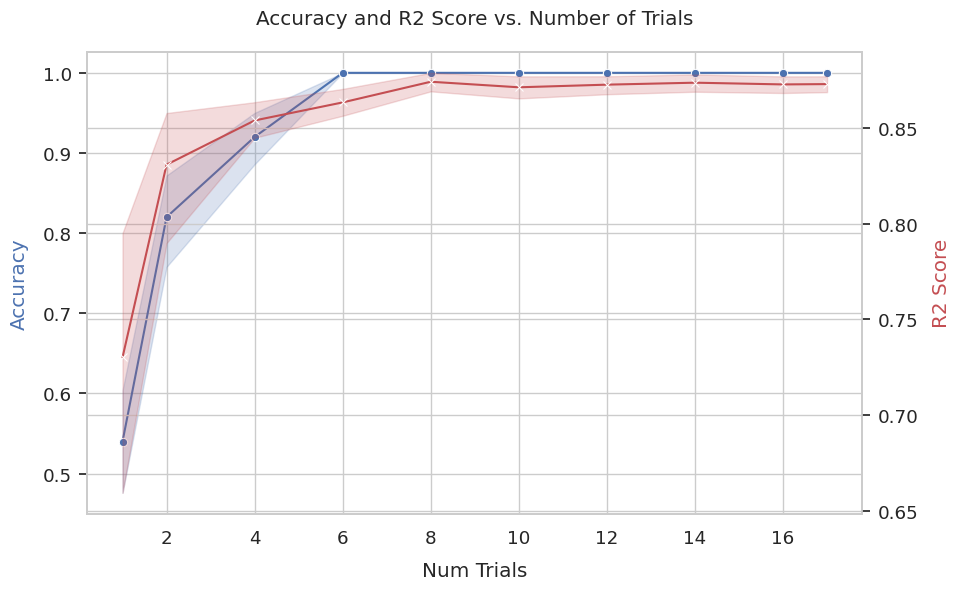

In [41]:
plot_min_trial_infer(df_exp3)

# Compute Forward Transfer

##### Method 1: We compare the performance of the model trained sequentially and task specific models (non CL). 

In [42]:
accuracies_CL = np.array(df_exp0_hnet_new_v0['R2_hnet'].values)
accuracies_control = np.array(df_exp1_control_new['R2_hnet'].values)
fwt = calculate_fwt(accuracies_CL, accuracies_control)
print(f"Forward Transfer (FWT): {fwt:.4f}")

Forward Transfer (FWT): 0.0083


##### Method 2: Here we compare the performance of the hnet on task i before training task i, with the performance of a randomly initialized model (not trained) on task i. 

In [43]:
fwt = 0

for i in range(20):
    df_forward_trans = create_table_FWT(df_exp0_hnet_v0, experiment0_hnet_v0, data_exp0_v0)
    accuracies_CL_before = np.array(df_forward_trans['R2_CL'].values)
    accuracies_control_random = np.array(df_forward_trans['R2_Random'].values)
    fwt_i = calculate_fwt(accuracies_CL_before, accuracies_control_random)
    fwt += fwt_i

fwt = fwt/20
print(f"Forward Transfer (FWT): {fwt:.4f}")

Created MLP Hypernet.
Hypernetwork with 1823425 weights and 130202 outputs (compression ratio: 14.00).
The network consists of 1822945 unconditional weights (1822945 internally maintained) and 480 conditional weights (480 internally maintained).
Created MLP Hypernet.
Hypernetwork with 1823425 weights and 130202 outputs (compression ratio: 14.00).
The network consists of 1822945 unconditional weights (1822945 internally maintained) and 480 conditional weights (480 internally maintained).
Created MLP Hypernet.
Hypernetwork with 1823425 weights and 130202 outputs (compression ratio: 14.00).
The network consists of 1822945 unconditional weights (1822945 internally maintained) and 480 conditional weights (480 internally maintained).
Created MLP Hypernet.
Hypernetwork with 1823425 weights and 130202 outputs (compression ratio: 14.00).
The network consists of 1822945 unconditional weights (1822945 internally maintained) and 480 conditional weights (480 internally maintained).
Created MLP Hype